In [7]:
# A simple notebook demonstrating how to extract an attention map from DinoV2 inference (with registers) 

# Most of the core code was originally published here:
#  https://gitlab.com/ziegleto-machine-learning/dino/-/tree/main/

# November 11th, 2023 by Lance Legel (lance@3co.ai) from 3co, Inc. (https://3co.ai)


# Additional resources:
# https://www.kaggle.com/code/stpeteishii/dino-visualize-self-attention-sample
# https://gitlab.com/ziegleto-machine-learning/dino/-/tree/main/


%load_ext autoreload
%autoreload 2

In [12]:
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
from torchvision import datasets, transforms
import numpy as np
from PIL import Image
from dinov2.models.vision_transformer import vit_small, vit_base, vit_large
from matplotlib.colors import Normalize

In [20]:
# These are settings for ensuring input images to DinoV2 are properly sized

class ResizeAndPad:
    def __init__(self, target_size, multiple):
        self.target_size = target_size
        self.multiple = multiple

    def __call__(self, img):
        # Resize the image
        img = transforms.Resize(self.target_size)(img)

        # Calculate padding
        pad_width = (self.multiple - img.width % self.multiple) % self.multiple
        pad_height = (self.multiple - img.height % self.multiple) % self.multiple

        # Apply padding
        img = transforms.Pad((pad_width // 2, pad_height // 2, pad_width - pad_width // 2, pad_height - pad_height // 2))(img)

        
        return img

# image_dimension = 952
image_dimension = 150
    
# This is what DinoV2 sees
target_size = (image_dimension, image_dimension)

# During inference / testing / deployment, we want to remove data augmentations from the input transform:
data_transforms = transforms.Compose([ ResizeAndPad(target_size, 14),
                                       transforms.CenterCrop(image_dimension),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.68622917, 0.68622917, 0.68622917], [0.10176649, 0.10176649, 0.10176649]),
                                     ]
                                     )

In [21]:
image_size = (image_dimension, image_dimension)
output_dir = '.'
patch_size = 14
# n_register_tokens = 4

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

model = vit_small(
        patch_size=14,
        img_size=526,
        init_values=1.0,
        # num_register_tokens=n_register_tokens,
        block_chunks=0
)

model.load_state_dict(torch.load('/home/hgf_mdc/hgf_ysb1444/checkpoints/dinov2_vits14_pretrain.pth'))
for p in model.parameters():
    p.requires_grad = False
model.to(device)
model.eval()

cpu


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

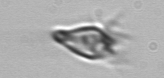

In [23]:
# URL of the image
# filename = "/hkfs/work/workspace_haic/scratch/hgf_ysb1444-plankton_ws/plankton-dinov2/images/800px-STS-124_launch_from_a_distance.jpg"
filename = "/home/hgf_mdc/hgf_ysb1444/data/2007/Tontonia_gracillima/IFCB1_2007_141_111713_00338.png"


original_image = Image.open(open(filename, 'rb'))
original_image = original_image.convert('RGB')

# Display the image
display(original_image)

(original_w, original_h) = original_image.size

img = data_transforms(original_image)

# make the image divisible by the patch size
w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
img = img[:, :w, :h]

w_featmap = img.shape[-2] // patch_size
h_featmap = img.shape[-1] // patch_size

img = img.unsqueeze(0)
img = img.to(device)

In [24]:
attention = model.get_last_self_attention(img.to(device))

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/hgf_mdc/hgf_ysb1444/micromamba/envs/dinov2/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/scratch/ipykernel_857261/1039912113.py", line 1, in <module>
    attention = model.get_last_self_attention(img.to(device))
  File "/hkfs/work/workspace_haic/scratch/hgf_ysb1444-plankton_ws/plankton-dinov2/dinov2/models/vision_transformer.py", line 381, in get_last_self_attention
    x = blk(x)
  File "/home/hgf_mdc/hgf_ysb1444/micromamba/envs/dinov2/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/hkfs/work/workspace_haic/scratch/hgf_ysb1444-plankton_ws/plankton-dinov2/dinov2/layers/block.py", line 294, in forward
    return super().forward(x_or_x_list, return_attention)
  File "/hkfs/work/workspace_haic/scratch/hgf_ysb1444-plankton_ws/plankton-dinov2/dinov2/layers/bl

In [ ]:
print("Attention {}: {}".format(attention.shape, attention))

In [ ]:
number_of_heads = attention.shape[1]

# attention tokens are packed in after the first token; the spatial tokens follow
# attention = attention[0, :, 0, 1 + n_register_tokens:].reshape(number_of_heads, -1)
attention = attention[0, :, 0, 1:].reshape(number_of_heads, -1)

In [ ]:
print(attention.shape)

In [ ]:
# resolution of attention from transformer tokens
attention = attention.reshape(number_of_heads, w_featmap, h_featmap)
print(attention.shape)

In [ ]:
# upscale to higher resolution closer to original image
attention = nn.functional.interpolate(attention.unsqueeze(0), scale_factor=patch_size, mode = "nearest")[0].cpu()
print(attention.shape)

In [ ]:
# sum all attention across the 12 different heads, to get one map of attention across entire image
attention = torch.sum(attention, dim=0)
print(attention.shape)

In [ ]:
# interpolate attention map back into original image dimensions
attention_of_image = nn.functional.interpolate(attention.unsqueeze(0).unsqueeze(0), size=(original_h, original_w), mode='bilinear', align_corners=False)
attention_of_image = attention_of_image.squeeze()
print(attention_of_image.shape)

In [ ]:
# Normalize image_metric to the range [0, 1]
image_metric = attention_of_image.numpy()
normalized_metric = Normalize(vmin=image_metric.min(), vmax=image_metric.max())(image_metric)

# Apply the Reds colormap
reds = plt.cm.Reds(normalized_metric)

# Create the alpha channel
alpha_max_value = 1.00  # Set your max alpha value

# Adjust this value as needed to enhance lower values visibility
gamma = 0.5  

# Apply gamma transformation to enhance lower values
enhanced_metric = np.power(normalized_metric, gamma)

# Create the alpha channel with enhanced visibility for lower values
alpha_channel = enhanced_metric * alpha_max_value

# Add the alpha channel to the RGB data
rgba_mask = np.zeros((image_metric.shape[0], image_metric.shape[1], 4))
rgba_mask[..., :3] = reds[..., :3]  # RGB
rgba_mask[..., 3] = alpha_channel  # Alpha

# Convert the numpy array to PIL Image
rgba_image = Image.fromarray((rgba_mask * 255).astype(np.uint8))

# Save the image
rgba_image.save('attention_mask.png')

In [ ]:
# Load the attention mask with PIL
attention_mask_image = Image.open("{}/attention_mask.png".format(output_dir))

# Ensure both images are in the same mode
if original_image.mode != 'RGBA':
    original_image = original_image.convert('RGBA')

# Overlay the second image onto the first image
# The second image must be the same size as the first image
original_image.paste(attention_mask_image, (0, 0), attention_mask_image)

# Save or show the combined image
original_image.save('image_with_attention.png')

# Or display it
display(original_image)